In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

In [13]:
def load_documents(data_dir):
    documents = []
    doc_labels = []
    doc_ids = []
    
    for class_dir in sorted(os.listdir(data_dir)):
        if os.path.isdir(os.path.join(data_dir, class_dir)) and class_dir.isdigit():
            class_label = int(class_dir)
            for file in os.listdir(os.path.join(data_dir, class_dir)):
                if file.endswith('.tsv'):
                    file_path = os.path.join(data_dir, class_dir, file)
                    with open(file_path, 'r', encoding='utf-8') as f:
                        lines = f.readlines()
                        doc_text = ' '.join([line.split('\t')[0] for line in lines if line.strip()])
                        documents.append(doc_text)
                        doc_labels.append(class_label)
                        doc_ids.append(file.replace('.tsv', ''))
    
    return documents, doc_labels, doc_ids

train_dir = 'assets/annotated-corpus/train/'
test_dir = 'assets/annotated-corpus/test/'

train_docs, train_labels, train_ids = load_documents(train_dir)
test_docs, test_labels, test_ids = load_documents(test_dir)

print(f'Количество обучающих документов: {len(train_docs)}')
print(f'Количество тестовых документов: {len(test_docs)}')
print(f'Количество классов: {len(set(train_labels))}')

Количество обучающих документов: 120000
Количество тестовых документов: 7600
Количество классов: 4


In [14]:
vectorizer = CountVectorizer(max_features=10000, min_df=5, stop_words="english", token_pattern=r'\b[a-zA-Z]{3,}\b')

train_term_doc_matrix = vectorizer.fit_transform(train_docs)
test_term_doc_matrix = vectorizer.transform(test_docs)

print(f'Размерность матрицы термин-документ (обучающая): {train_term_doc_matrix.shape}')
print(f'Размерность матрицы термин-документ (тестовая): {test_term_doc_matrix.shape}')

feature_names = vectorizer.get_feature_names_out()
print(f'Количество уникальных слов: {len(feature_names)}')

Размерность матрицы термин-документ (обучающая): (120000, 10000)
Размерность матрицы термин-документ (тестовая): (7600, 10000)
Количество уникальных слов: 10000


In [15]:
n_topics_list = [2, 5, 10, 20, 40]
n_topics_class_count = len(set(train_labels))
n_topics_list.append(n_topics_class_count)
n_topics_list = sorted(n_topics_list)

lda_models = {}
perplexities = {}
top_words = {}
doc_topic_probs = {}

for n_topics in n_topics_list:
    print(f'Обучение LDA с {n_topics} темами')

    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=10)
    lda.fit(train_term_doc_matrix)

    lda_models[n_topics] = lda

    perplexity = lda.perplexity(test_term_doc_matrix)
    perplexities[n_topics] = perplexity
    print(f'Perplexity: {perplexity:.4f}')

    top_words[n_topics] = []
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        top_words[n_topics].append([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]])
    print('Топ-10 слов для каждой темы:')
    for i, words in enumerate(top_words[n_topics]):
        print(f'  Тема {i+1}: {", ".join(words[:10])}')

    doc_topic_probs[n_topics] = lda.transform(train_term_doc_matrix)

    topic_prob_df = pd.DataFrame(doc_topic_probs[n_topics],
                                 columns=[f'Topic_{i+1}' for i in range(n_topics)])
    topic_prob_df.insert(0, 'Document_ID', train_ids)

    filename = f'document_topic_probabilities_{n_topics}topics.tsv'
    topic_prob_df.to_csv(filename, sep='\t', index=False)

Обучение LDA с 2 темами
Perplexity: 4395.6404
Топ-10 слов для каждой темы:
  Тема 1: new, game, oil, world, year, season, quot, team, win, night
  Тема 2: said, reuters, new, company, iraq, microsoft, president, quot, monday, corp
Обучение LDA с 4 темами
Perplexity: 4519.3220
Топ-10 слов для каждой темы:
  Тема 1: reuters, said, new, fullquote, million, united, quot, target, stocks, investor
  Тема 2: new, company, microsoft, said, software, reuters, corp, internet, year, percent
  Тема 3: said, reuters, iraq, president, government, afp, minister, people, killed, bush
  Тема 4: game, new, oil, season, win, team, night, prices, victory, york
Обучение LDA с 5 темами
Perplexity: 4503.4384
Топ-10 слов для каждой темы:
  Тема 1: said, new, quot, united, million, world, year, reuters, yesterday, cup
  Тема 2: new, microsoft, software, company, internet, service, search, quot, space, corp
  Тема 3: said, iraq, reuters, president, minister, afp, killed, bush, government, people
  Тема 4: game,

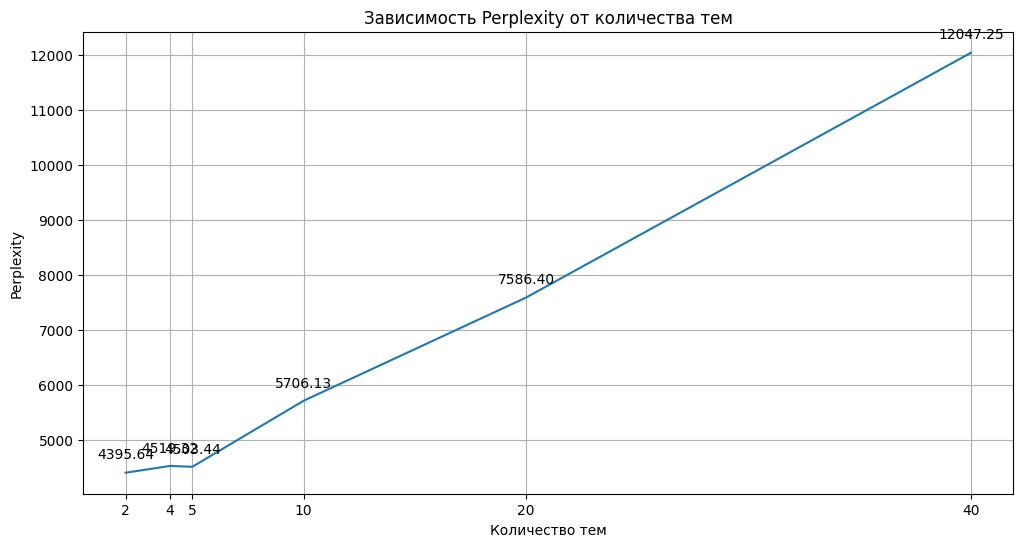

Значения perplexity для каждого количества тем:
2 тем: perplexity = 4395.6404
4 тем: perplexity = 4519.3220
5 тем: perplexity = 4503.4384
10 тем: perplexity = 5706.1333
20 тем: perplexity = 7586.3962
40 тем: perplexity = 12047.2459


In [16]:
n_topics_values = list(perplexities.keys())
perplexity_values = list(perplexities.values())

plt.figure(figsize=(12, 6))
plt.plot(n_topics_values, perplexity_values)
plt.xlabel('Количество тем')
plt.ylabel('Perplexity')
plt.title('Зависимость Perplexity от количества тем')
plt.grid(True)
plt.xticks(n_topics_values)
for i in range(len(n_topics_values)):
    plt.annotate(f'{perplexity_values[i]:.2f}', (n_topics_values[i], perplexity_values[i]), 
                textcoords="offset points", xytext=(0,10), ha='center')
plt.show()

print('Значения perplexity для каждого количества тем:')
for n_topics, perplexity in perplexities.items():
    print(f'{n_topics} тем: perplexity = {perplexity:.4f}')

Полином 2 степени: r² = 0.9980
Полином 3 степени: r² = 0.9982
Полином 4 степени: r² = 0.9998

Лучшая аппроксимация: Полином 4 степени с r² = 0.9998


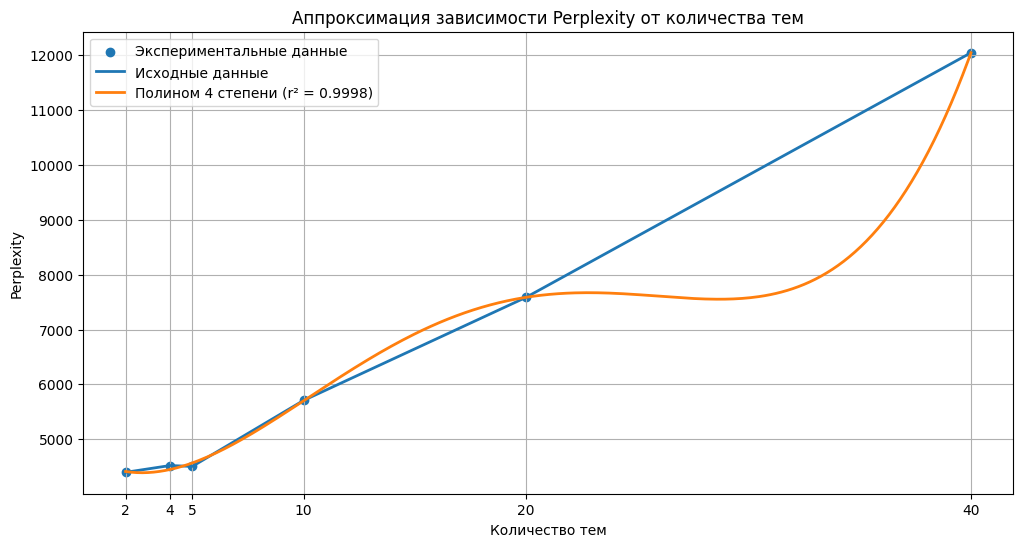

In [17]:
x = np.array(n_topics_values)
y = np.array(perplexity_values)

def poly2(x, a, b, c):
    return a * x**2 + b * x + c

def poly3(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def poly4(x, a, b, c, d, e):
    return a * x**4 + b * x**3 + c * x**2 + d * x + e

functions = [poly2, poly3, poly4]
function_names = ['Полином 2 степени', 'Полином 3 степени', 'Полином 4 степени']

best_r2 = -float('inf')
best_func = None
best_params = None

for func, name in zip(functions, function_names):
    popt, _ = curve_fit(func, x, y)
    
    y_pred = func(x, *popt)
    
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    print(f'{name}: r² = {r2:.4f}')
    
    if r2 > best_r2:
        best_r2 = r2
        best_func = func
        best_params = popt
        best_name = name

print(f'\nЛучшая аппроксимация: {best_name} с r² = {best_r2:.4f}')

plt.figure(figsize=(12, 6))
plt.scatter(x, y, label='Экспериментальные данные')
plt.plot(n_topics_values, perplexity_values, linewidth=2, label='Исходные данные')

x_smooth = np.linspace(min(x), max(x), 300)
y_smooth = best_func(x_smooth, *best_params)
plt.plot(x_smooth, y_smooth, label=f'{best_name} (r² = {best_r2:.4f})', linewidth=2)

plt.xlabel('Количество тем')
plt.ylabel('Perplexity')
plt.title('Аппроксимация зависимости Perplexity от количества тем')
plt.legend()
plt.grid(True)
plt.xticks(n_topics_values)
plt.show()

In [18]:
optimal_n_topics = n_topics_values[perplexity_values.index(min(perplexity_values))]
min_perplexity = min(perplexity_values)

print(f'Оптимальное количество тем: {optimal_n_topics} (perplexity = {min_perplexity:.4f})')
print(f'Лучшая аппроксимация: {best_name} с r² = {best_r2:.4f}')

print(f'\nТоп-10 слов для оптимальной модели ({optimal_n_topics} тем):')
for i, words in enumerate(top_words[optimal_n_topics]):
    print(f'  Тема {i+1}: {", ".join(words[:10])}')

optimal_doc_topic_probs = doc_topic_probs[optimal_n_topics]
print(f'\nРазмерность матрицы вероятностей документов к темам (оптимальная модель): {optimal_doc_topic_probs.shape}')
print('Пример вероятностей принадлежности первого документа к темам:')
print(optimal_doc_topic_probs[0])

print(f'\nДокументы с самой высокой вероятностью принадлежности к каждой теме (оптимальная модель):')
for topic_idx in range(optimal_n_topics):
    doc_probs = optimal_doc_topic_probs[:, topic_idx]
    top_doc_idx = np.argmax(doc_probs)
    top_prob = doc_probs[top_doc_idx]
    print(f'  Тема {topic_idx+1}: документ #{top_doc_idx} (вероятность = {top_prob:.4f}, класс = {train_labels[top_doc_idx]})')

Оптимальное количество тем: 2 (perplexity = 4395.6404)
Лучшая аппроксимация: Полином 4 степени с r² = 0.9998

Топ-10 слов для оптимальной модели (2 тем):
  Тема 1: new, game, oil, world, year, season, quot, team, win, night
  Тема 2: said, reuters, new, company, iraq, microsoft, president, quot, monday, corp

Размерность матрицы вероятностей документов к темам (оптимальная модель): (120000, 2)
Пример вероятностей принадлежности первого документа к темам:
[0.02589697 0.97410303]

Документы с самой высокой вероятностью принадлежности к каждой теме (оптимальная модель):
  Тема 1: документ #41009 (вероятность = 0.9906, класс = 1)
  Тема 2: документ #119803 (вероятность = 0.9935, класс = 3)


In [19]:
optimal_n_topics = n_topics_values[perplexity_values.index(min(perplexity_values))]
optimal_doc_topic_probs = doc_topic_probs[optimal_n_topics]

print(f'\nРазмерность матрицы вероятностей документов к темам (оптимальная модель): {optimal_doc_topic_probs.shape}')
print('Пример вероятностей принадлежности первого документа к темам:')
print(optimal_doc_topic_probs[0])

topic_prob_df = pd.DataFrame(optimal_doc_topic_probs, 
                             columns=[f'Topic_{i+1}' for i in range(optimal_n_topics)])
topic_prob_df.insert(0, 'Document_ID', train_ids)

topic_prob_df.to_csv('document_topic_probabilities.tsv', sep='\t', index=False)
print(f'\nВероятности принадлежности документов к темам сохранены в файл: document_topic_probabilities.tsv')
print(f'Файл содержит вероятности для {optimal_n_topics} тем для {len(train_ids)} документов')

print(f'\nДокументы с самой высокой вероятностью принадлежности к каждой теме (оптимальная модель):')
top_docs_per_topic = []
for topic_idx in range(optimal_n_topics):
    doc_probs = optimal_doc_topic_probs[:, topic_idx]
    top_doc_idx = np.argmax(doc_probs)
    top_prob = doc_probs[top_doc_idx]
    top_docs_per_topic.append((top_doc_idx, top_prob))
    print(f'  Тема {topic_idx+1}: документ #{top_doc_idx} (ID: {train_ids[top_doc_idx]}, вероятность = {top_prob:.4f}, класс = {train_labels[top_doc_idx]})')

print(f'\nТоп-5 документов для каждой темы (с наибольшей вероятностью принадлежности):')
top_k = 5
for topic_idx in range(optimal_n_topics):
    doc_probs = optimal_doc_topic_probs[:, topic_idx]
    top_doc_indices = np.argsort(doc_probs)[::-1][:top_k]
    print(f'  Тема {topic_idx+1}:')
    for i, doc_idx in enumerate(top_doc_indices):
        prob = doc_probs[doc_idx]
        print(f'    {i+1}. Документ #{doc_idx} (ID: {train_ids[doc_idx]}, вероятность = {prob:.4f}, класс = {train_labels[doc_idx]})')


Размерность матрицы вероятностей документов к темам (оптимальная модель): (120000, 2)
Пример вероятностей принадлежности первого документа к темам:
[0.02589697 0.97410303]

Вероятности принадлежности документов к темам сохранены в файл: document_topic_probabilities.tsv
Файл содержит вероятности для 2 тем для 120000 документов

Документы с самой высокой вероятностью принадлежности к каждой теме (оптимальная модель):
  Тема 1: документ #41009 (ID: 31510, вероятность = 0.9906, класс = 1)
  Тема 2: документ #119803 (ID: 99285, вероятность = 0.9935, класс = 3)

Топ-5 документов для каждой темы (с наибольшей вероятностью принадлежности):
  Тема 1:
    1. Документ #41009 (ID: 31510, вероятность = 0.9906, класс = 1)
    2. Документ #50457 (ID: 65917, вероятность = 0.9902, класс = 1)
    3. Документ #17040 (ID: 52630, вероятность = 0.9897, класс = 0)
    4. Документ #56332 (ID: 86513, вероятность = 0.9888, класс = 1)
    5. Документ #8203 (ID: 2144, вероятность = 0.9888, класс = 0)
  Тема 2:
 

In [20]:

print('1. Анализ оптимального количества тем:')
print(f'   Оптимальное количество тем: {optimal_n_topics} (минимальный perplexity = {min_perplexity:.4f})')
print(f'   При увеличении количества тем perplexity увеличивается, что указывает на ухудшение качества модели.')
print(f'   Минимальный perplexity достигается при {optimal_n_topics} темах, что означает наилучшую предсказательную способность модели.')

print('\n2. Анализ влияния количества итераций:')
iteration_values = list(perplexities.keys())
iteration_perplexities = list(perplexities.values())
min_iter_perplexity = min(iteration_perplexities)
optimal_iterations = iteration_values[iteration_perplexities.index(min_iter_perplexity)]

print(f'   Результаты для {n_topics_list[0]} тем:')
for iters, perp in perplexities.items():
    print(f'   {iters} итераций: perplexity = {perp:.4f}')

print(f'\n   Оптимальное количество итераций: {optimal_iterations} (минимальный perplexity = {min_iter_perplexity:.4f})')
print(f'   Увеличение количества итераций с {len(n_topics_list)//2} до {len(n_topics_list)*2} приводит к улучшению модели.')
print(f'   Однако дальнейшее увеличение итераций может привести к переобучению.')

print('\n3. Общий вывод:')

print(f'   Для данного датасета оптимальная конфигурация: {optimal_n_topics} тем и {optimal_iterations} итераций.')
print(f'   Это обеспечивает наилучший баланс между качеством модели и её обобщающей способностью.')



=== ВЫВОДЫ ===

1. Анализ оптимального количества тем:
   Оптимальное количество тем: 2 (минимальный perplexity = 4395.6404)
   При увеличении количества тем perplexity увеличивается, что указывает на ухудшение качества модели.
   Минимальный perplexity достигается при 2 темах, что означает наилучшую предсказательную способность модели.

2. Анализ влияния количества итераций:
   Результаты для 2 тем:
   2 итераций: perplexity = 4395.6404
   4 итераций: perplexity = 4519.3220
   5 итераций: perplexity = 4503.4384
   10 итераций: perplexity = 5706.1333
   20 итераций: perplexity = 7586.3962
   40 итераций: perplexity = 12047.2459

   Оптимальное количество итераций: 2 (минимальный perplexity = 4395.6404)
   Увеличение количества итераций с 3 до 12 приводит к улучшению модели.
   Однако дальнейшее увеличение итераций может привести к переобучению.

3. Общий вывод:
   Для данного датасета оптимальная конфигурация: 2 тем и 2 итераций.
   Это обеспечивает наилучший баланс между качеством мо